# Collaboration and Competition

---

In this notebook, we will usethe Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from src.agents import MADDPGAgent
from src.models import CriticArchitecture, ActorArchitecture
import matplotlib.pyplot as plt
from src.rl_utilities import plot_smoothed_return
from IPython.display import clear_output
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./envs/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
batch_size = 128  # Size of the batch to train the neural networks
n_episodes = 4000 # Number of episodes to run when training the agent
n_batches_train = 1 # Number of times to train for each time step
n_agents = 2 # Number of agents
exp_replay_buffer_size = int(1e5) # Experience replay buffer size
epsilon_decay =  1 # Decay of the exploration constant
epsilon = 1 # Initial value of the exploration constant
epsilon_final = 0.1 # Final value of the exploration constant
plot_every_n = 10 # Period to update the rewards chart
save_every_n = 1 # Period to save the model if an improvement has been found
tau = 0.02 # Parameter that controls how fast the local networks update the target networks
gamma = 0.99 # Discount factor

In [6]:
agent = MADDPGAgent(CriticArchitecture, ActorArchitecture, state_size=state_size, action_size=action_size, n_agents=n_agents,
                  tau=tau, gamma=gamma, batch_size=batch_size, replay_size = exp_replay_buffer_size,
                  n_batches_train=n_batches_train, random_seed=655321)
scores = [] 
epsilons = []
buffer_sizes = []
max_score = 0
actions_unique=set()

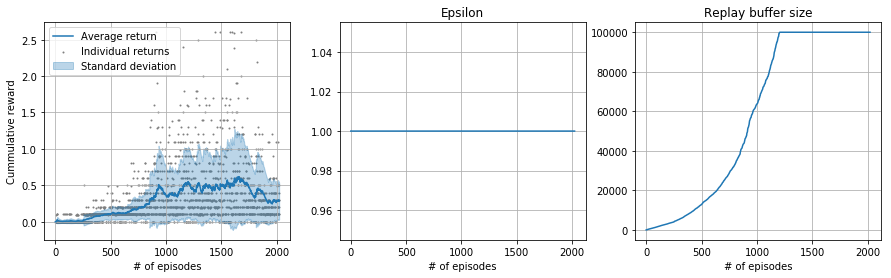

In [10]:
for episode in range(n_episodes):
    epsilons.append(epsilon)
    epsilon = epsilon_decay * epsilon + (1-epsilon_decay) * epsilon_final
    env_info = env.reset(train_mode=True)[brain_name] 
    agent.reset()
    state = env_info.vector_observations
    score = []
    done = [False]
    c = 0
    while not any(done):
        # take random action
        action = agent.act(state, epsilon=epsilon)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += [reward]
        c += 1
        #actions_unique = actions_unique.union(set(np.unique(action)))

    scores.append(np.max(np.sum(score, axis=0)))
    buffer_sizes.append(agent.replay_buffer.length)
    
    if (episode+1) % plot_every_n == 0:
        clear_output(True)
        plt.figure(figsize=(15, 4))
        plt.subplot(1,3,1)
        plot_smoothed_return(scores)
        plt.subplot(1,3,2)
        plt.grid()
        plt.plot(epsilons)
        plt.xlabel("# of episodes")
        plt.title("Epsilon")
        plt.subplot(1,3,3)
        plt.grid()
        plt.plot(buffer_sizes)
        plt.xlabel("# of episodes")
        plt.title("Replay buffer size")
        plt.show()
        
    if (episode + 1) % save_every_n == 0:
        if max_score < np.mean(scores[-100:]): 
            for i, ddpg_agent in enumerate(agent.agents):
                torch.save(ddpg_agent.critic_local.state_dict(), f'checkpoint_critic_local_tennis_{i}.pth')
                torch.save(ddpg_agent.critic_target.state_dict(), f'checkpoint_critic_target_tennis_{i}.pth')
                torch.save(ddpg_agent.actor_local.state_dict(), f'checkpoint_actor_local_tennis_{i}.pth')
                torch.save(ddpg_agent.actor_target.state_dict(), f'checkpoint_actor_target_tennis_{i}.pth')
                max_score = np.mean(scores[-100:])

In [11]:
agent = MADDPGAgent(CriticArchitecture, ActorArchitecture, state_size=state_size, action_size=action_size, n_agents=n_agents,
                  tau=tau, gamma=gamma, batch_size=batch_size, replay_size = exp_replay_buffer_size,
                  n_batches_train=n_batches_train, random_seed=655321)
for i, ddpg_agent in enumerate(agent.agents):
    ddpg_agent.critic_local.load_state_dict(torch.load(f'checkpoint_critic_local_tennis_{i}.pth'))
    ddpg_agent.critic_target.load_state_dict(torch.load(f'checkpoint_critic_target_tennis_{i}.pth'))
    ddpg_agent.actor_local.load_state_dict(torch.load(f'checkpoint_actor_local_tennis_{i}.pth'))
    ddpg_agent.actor_target.load_state_dict(torch.load(f'checkpoint_actor_target_tennis_{i}.pth'))


In [13]:
rewards=[]
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations
done=[False]
while not any(done):
    # take random action
    action = agent.act(state, epsilon=epsilon)
    env_info = env.step(action)[brain_name]
    state = env_info.vector_observations
    done = env_info.local_done
    reward = env_info.rewards
    rewards.append(reward)


C:\Users\Ivan Valles Perez\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
